# Bibliotecas

In [530]:
import pandas as pd
import numpy as np
import ruptures as rpt
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare
from scipy.stats import chisquare

# Funções

In [532]:
# Teste de estacionariedade
def stationarity_test(series):
    result = adfuller(series)

    if result[1] < 0.05:
        print("Série estacionária com 0 graus de diferenciação")

    result = adfuller(series.diff().dropna())

    if result[1] < 0.05:
        print("Série estacionária com 1 grau de diferenciação")

    result = adfuller(series.diff().diff().dropna())

    if result[1] < 0.05:
        print("Série estacionária com 2 graus de diferenciação")

    result = adfuller(series.diff().diff().diff().dropna())

    if result[1] < 0.05:
        print("Série estacionária com 3 graus de diferenciação")

In [533]:
# Teste de sazonalidade
def seasonality_test(series, seasonLength):
    idx = np.arange(len(series)) % seasonLength
    season = pd.DataFrame(zip(*[series, idx]), columns=["series", "idx"])
    
    try:
        H_statistic, p_value = friedmanchisquare(*[season[(season['idx'] == s)]['series'] for s in season['idx'].unique()])
    
        if p_value < 0.05:
            print(f"Friedman Chi-Square: Sazonal a 5% de significância com temporada {seasonLength}")
        else:
            print(f"Friedman Chi-Square: Não-sazonal a 5% de significância com temporada {seasonLength}")

    except Exception as ex:
        pass

In [534]:
# Plot de autocorrelação
def autocorr_plot(series):
    corr_array = acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0, corr_array[0][x]), mode='lines', line_color='#3f3f3f') for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4', marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines', fillcolor='rgba(32,146,230,0.3)', fill='tonexty',
                   line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    title='Autocorrelação'
    fig.update_layout(title=title)
    fig.show()

In [535]:
# Plot de autocorrelação parcial
def partial_autocorr_plot(series):
    corr_array = pacf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0, corr_array[0][x]), mode='lines', line_color='#3f3f3f') for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4', marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines', fillcolor='rgba(32,146,230,0.3)', fill='tonexty',
                   line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    title='Autocorrelação Parcial'
    fig.update_layout(title=title)
    fig.show()

In [536]:
# Plot da série original
def plot(data, col1, col2):
    fig = px.line(data, x = col1, y = col2)
    fig.show()

In [537]:
# Fit e feature selection
def auto_sarima(data, min_diff=0, max_diff=2):
    reduzir_variaveis = False
    valores_negativos = False
    series = []
    
    for ar in range (0, 5):
        for i in range (min_diff, max_diff + 1):
            for ma in range (0, 5):
                reduzir_variaveis = False
                valores_negativos = False
                
                try:
                    model = ARIMA(data, order=(ar,i,ma))
                    model_fit = model.fit()

                except:
                    continue
                    
                p_valores = pd.read_html(model_fit.summary().tables[1].as_html())
                p_valores = p_valores[0].values.tolist()[1:]
                p_valores = [[sublist[0], sublist[4]] for sublist in p_valores]

                for linha in p_valores:
                    if linha[0] == "const" or linha[0] == "sigma2":
                        continue

                    else:
                        if float(linha[1]) > 0.05:
                            reduzir_variaveis = True
                            break

                if not all(valor >= 0 for valor in model_fit.predict(start = 1, end = len(data))):
                    valores_negativos = True

                AIC = pd.read_html(model_fit.summary().tables[0].as_html())
                AIC = AIC[0].values.tolist()
                AIC = AIC[2][3]

                if AIC < 25:
                    reduzir_variaveis = True  # erro pequeno demais, gera modelos ruins
                    
                if not reduzir_variaveis and not valores_negativos:
                    series.append([AIC, ar, i, ma])

    # checa se uma série boa existe
    existe_serie = False
    for serie in series:
        if serie[1] != 0 or serie[3] != 0:
            existe_serie = True

    if existe_serie:
        melhor = series[0]
        for serie in series:
            if serie[0] < melhor[0] and (serie[1] != 0 or serie[3] != 0):
                melhor = serie
    
        return melhor

    else: # tenta de novo com um nivel de significancia maior
        print("Não foi possível encontrar uma série com com covaráveis significativas a 5% de significância, tentando novamente com 40%")
        series = []
        
        for ar in range (0, 5):
            for i in range (min_diff, max_diff + 1):
                for ma in range (0, 5):
                    reduzir_variaveis = False
                    valores_negativos = False
                    
                    try:
                        model = ARIMA(data, order=(ar,i,ma))
                        model_fit = model.fit()

                    except:
                        continue
                    
                    p_valores = pd.read_html(model_fit.summary().tables[1].as_html())
                    p_valores = p_valores[0].values.tolist()[1:]
                    p_valores = [[sublist[0], sublist[4]] for sublist in p_valores]

                    for linha in p_valores:
                        if linha[0] == "const" or linha[0] == "sigma2":
                            continue

                        else:
                            if float(linha[1]) > 0.4:
                                reduzir_variaveis = True
                                break

                    if not all(valor >= 0 for valor in model_fit.predict(start = 1, end = len(data))):
                        valores_negativos = True

                    AIC = pd.read_html(model_fit.summary().tables[0].as_html())
                    AIC = AIC[0].values.tolist()
                    AIC = AIC[2][3]
    
                    if AIC < 25:
                        reduzir_variaveis = True  # erro pequeno demais, gera modelos ruins
                    
                    if not reduzir_variaveis and not valores_negativos:
                        series.append([AIC, ar, i, ma])
        print(series)
        existe_serie = False
        for serie in series:
            if serie[1] != 0 or serie[3] != 0:
                existe_serie = True
        
        if existe_serie:
            melhor = series[0]
            for serie in series:
                if (melhor[1] == 0 and melhor[3] == 0) and (serie[1] != 0 or serie[3] != 0):
                    melhor = serie
                elif serie[0] < melhor[0]:
                    melhor = serie
                else:
                    continue
        
            return melhor

        else:
            
            melhor = series[0]
            for serie in series:
                if serie[0] < melhor[0]:
                    melhor = serie
    
            return melhor    
        
        melhor = series[0]
        for serie in series:
            if serie[0] < melhor[0]:
                melhor = serie

        return melhor

In [538]:
# Plot e predição (5 anos)
def plot_prediction(model_fit, data, col1, col2):
    predicao = []
    ano = [2023, 2024, 2025, 2026, 2027, 2028]

    for i in range(0, len(ano)):
        predicao.append([ano[i], model_fit.predict(start=len(data)+i).values.tolist()[0]])

    predicao = pd.DataFrame(predicao, columns=["Ano", "Previsão"])

    fig = go.Figure(data=go.Scatter(x=data[col1], y=data[col2], name="Real"))
    fig.add_trace(go.Scatter(x=data[col1], y=model_fit.predict(start=1, end=len(data)), name="Modelo"))
    fig.add_trace(go.Scatter(x=predicao["Ano"], y=predicao["Previsão"], name="Previsão"))

    fig.show()

In [539]:
def plot_avaliacao(model, data, col1, col2):
    avaliacao = []

    for i in range(5, len(data[col2])):
        model_fit = ARIMA(data[data[col2] <= min(data[col2].values.tolist()) + i][col1], order=(model[1],model[2],model[3])).fit()
        avaliacao.append([min(data[col2].values.tolist()) + i, model_fit.predict(start=i).values.tolist()[0]])

    avaliacao = pd.DataFrame(avaliacao, columns=["Ano", "Previsão"])
    fig = go.Figure(data=go.Scatter(x=data[col2], y=data[col1], name="Real"))
    fig.add_trace(go.Scatter(x=avaliacao["Ano"], y=avaliacao["Previsão"], name="Avaliação"))

    fig.show()

In [540]:
def reducao_serie(data, col1, col2, penalidade = "a"):
    if penalidade == "a":
        penalidade = 2 * np.log(len(data[col1]))
    
    model = "rbf"
    algo = rpt.Pelt(model=model).fit(data[col1].values)
    result = algo.predict(pen = penalidade)

    fig = px.line(data, x=col1, y=col2)
    fig.add_vline(x=data.iloc[0][col1])
    
    for resul in result:
        fig.add_vline(x=data.iloc[resul - 1][col1])

    fig.show()

    if len(result) == 1:
        return data
    else:
        return data.iloc[result[-2] - 1:]

In [541]:
def cotovelo(data, col1, col2):
    plot = []
    
    for i in np.arange(0, len(data[col1]), 0.01):
        model = "rbf"
        algo = rpt.Pelt(model=model).fit(data[col1].values)
        result = algo.predict(pen = i)
        plot.append(len(result))

    fig = px.line(x=np.arange(0, len(data[col1]), 0.01), y=plot)
    fig.show()

# Modelagens

## Redação

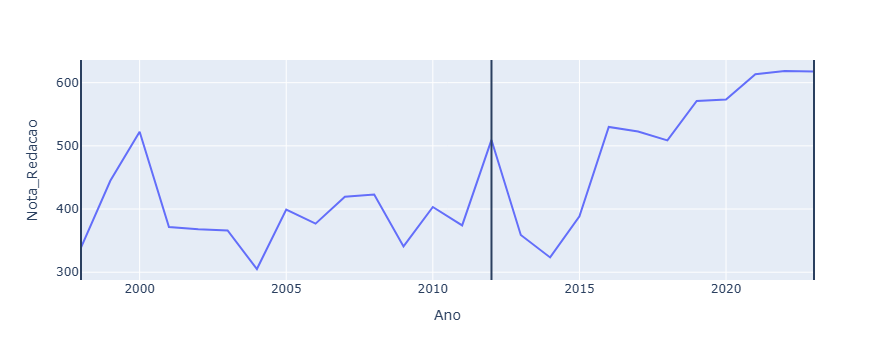

In [544]:
df = reducao_serie(pd.read_excel("MÉDIA_ENEM_SF.xlsx"), "Ano", "Nota_Redacao")

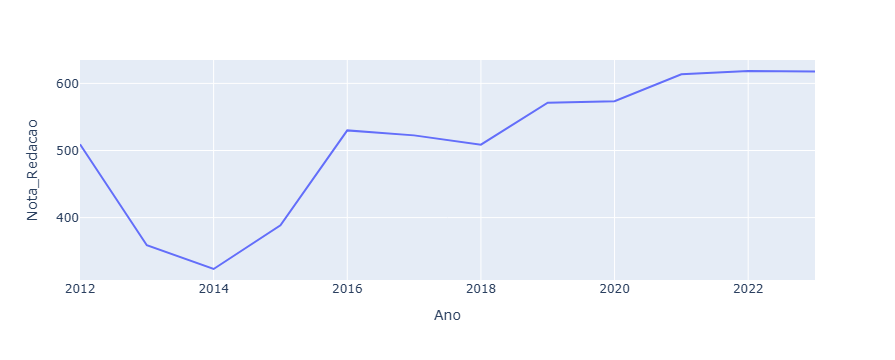

In [545]:
plot(df, "Ano", "Nota_Redacao")

In [546]:
stationarity_test(df["Nota_Redacao"])

Série estacionária com 0 graus de diferenciação
Série estacionária com 1 grau de diferenciação
Série estacionária com 2 graus de diferenciação


In [547]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_Redacao"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 3
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 4
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 6


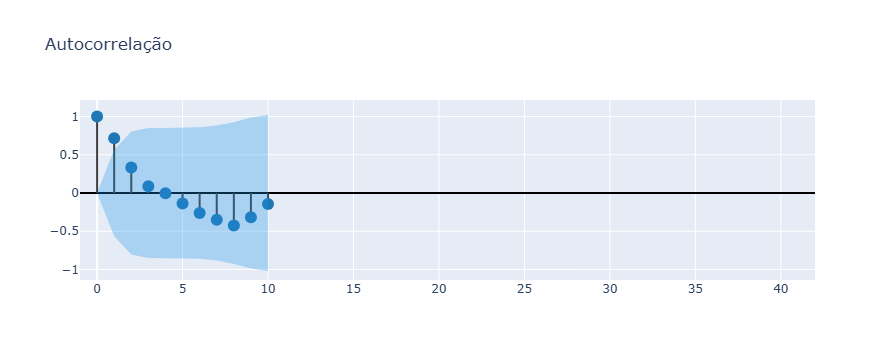

In [548]:
autocorr_plot(df["Nota_Redacao"].dropna())

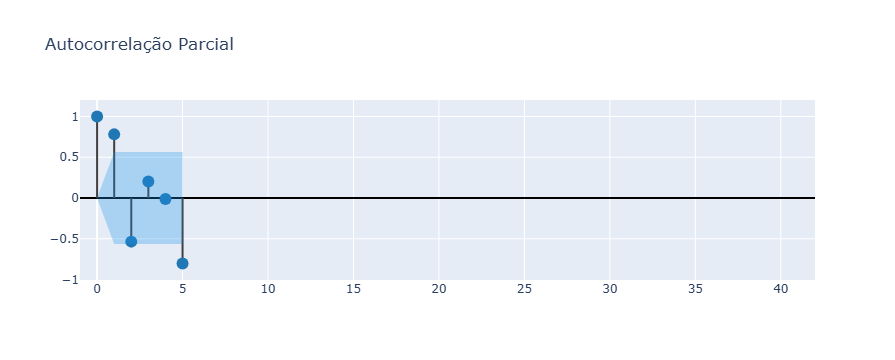

In [549]:
partial_autocorr_plot(df["Nota_Redacao"].dropna())

In [550]:
auto = auto_sarima(df["Nota_Redacao"], min_diff=0, max_diff=2)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[139.568, 2, 0, 0]


C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [551]:
ARIMA(df["Nota_Redacao"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Nota_Redacao   No. Observations:                   12
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -65.784
Date:                Fri, 06 Jun 2025   AIC                            139.568
Time:                        09:19:46   BIC                            141.508
Sample:                             0   HQIC                           138.850
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        528.8765     57.699      9.166      0.000     415.789     641.964
ar.L1          1.1818      0.370      3.196      0.001       0.457       1.907
ar.L2         -0.6021      0.181     -3.320      0.001      -0.958      -0.247
sigma2      2938.4342   1443.888      2.035      0.042     108.465    5768.403
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.50
Prob(Q):                              0.88   Prob(JB):                         0.47
Heteroskedasticity (H):               0.32   Skew:                            -0.87
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

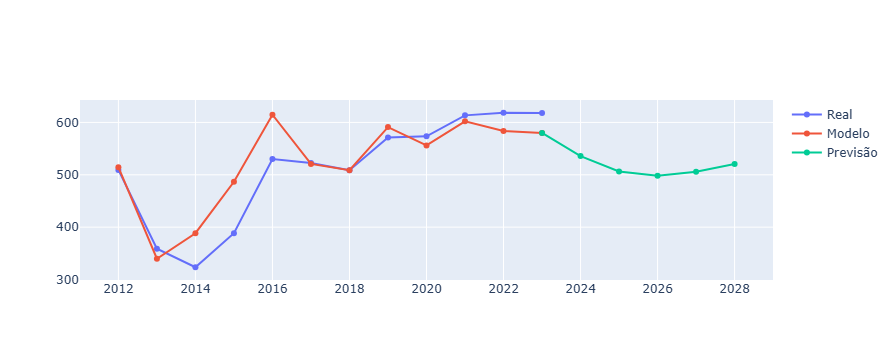

In [552]:
plot_prediction(ARIMA(df["Nota_Redacao"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_Redacao")

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was pro

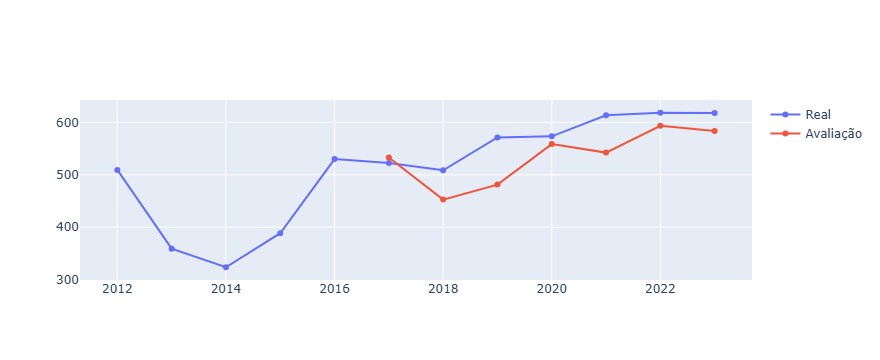

In [553]:
plot_avaliacao(auto, df, "Nota_Redacao", "Ano")

## Competência 1

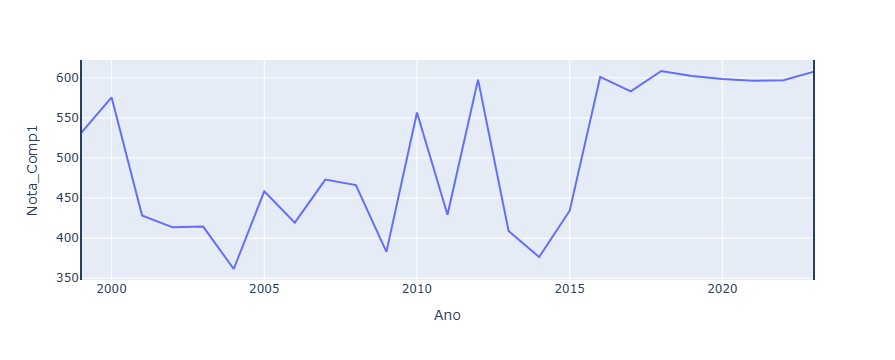

Unnamed: 0.1  Unnamed: 0   Ano  Nota_Comp1  Nota_Comp2  Nota_Comp3  \
0              0           0  1999  531.067790  449.855909  424.386261   
1              0           0  2000  575.660111  514.950941  500.111978   
2              0           0  2001  428.334832  345.901511  355.093777   
3              0           0  2002  413.477654  358.985286  349.844595   
4              0           0  2003  414.482785  360.114816  350.030218   
5              0           0  2004  361.531192  293.961330  287.609708   
6              0           0  2005  458.425699  408.971387  391.944052   
7              0           0  2006  419.361965  402.566872  374.170166   
8              0           0  2007  473.037432  451.772957  410.928831   
9              0           0  2008  466.170064  442.316609  405.036243   
10             0           0  2009  382.874055  358.058419  332.113851   
11             0           0  2010  556.848628  506.280316  473.980335   
12             0           0  2011  429.120924  406.820903  374.623756   
13             0           0  2012  597.744597  557.684448  529.316520   
14             0           0  2013  408.848031  381.588831  372.169455   
15             0           0  2014  376.497738  334.584896  319.794602   
16             0           0  2015  434.254012  410.542008  397.389456   
17             0           0  2016  601.221741  560.509975  535.984139   
18             0           0  2017  583.194817  559.302628  530.596178   
19             0           0  2018  608.531381  507.757199  485.002736   
20             0           0  2019  602.386896  613.680062  574.062750   
21             0           0  2020  598.658529  609.437574  551.719048   
22             0           0  2021  596.328340  690.134625  576.558698   
23             0           0  2022  596.961389  704.804523  574.342976   
24             0           0  2023  607.725915  696.476140  592.545232   

    Nota_Comp4  Nota_Comp5  
0   420.115253  346.979014  
1   526.948161  493.401199  
2   397.530477  330.179590  
3   366.823450  350.760669  
4   363.157801  343.147099  
5   314.784978  267.551381  
6   398.340120  337.361276  
7   367.542849  320.627870  
8   398.844103  362.559547  
9   400.995632  399.849678  
10  331.426922  299.228648  
11  479.283709  407.394683  
12  379.007048  281.006412  
13  554.179060  307.863778  
14  397.267558  234.706350  
15  355.944299  230.287722  
16  414.764338  285.098101  
17  566.958692  385.145516  
18  539.988918  399.698471  
19  584.737492  357.371735  
20  608.140666  457.656973  
21  617.431067  489.817402  
22  640.926362  563.554421  
23  647.192195  569.097416  
24  648.985082  543.259987

In [555]:
df = reducao_serie(pd.read_excel("MÉDIA_ENEM_COMP_SF.xlsx"), "Ano", "Nota_Comp1")
df

In [556]:
stationarity_test(df["Nota_Comp1"])

Série estacionária com 1 grau de diferenciação
Série estacionária com 2 graus de diferenciação


In [557]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_Comp1"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


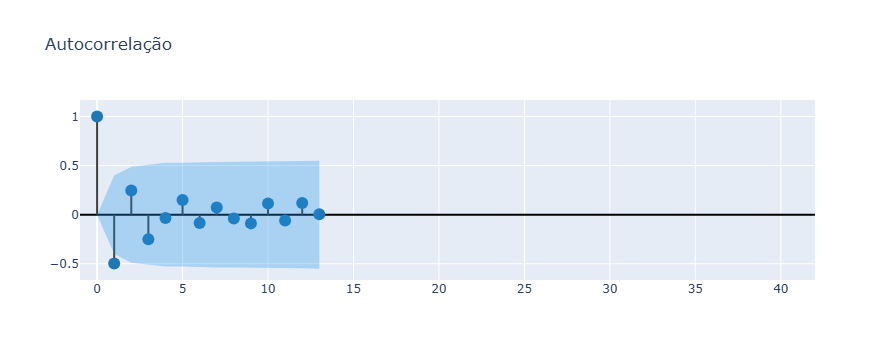

In [558]:
autocorr_plot(df["Nota_Comp1"].diff().dropna())

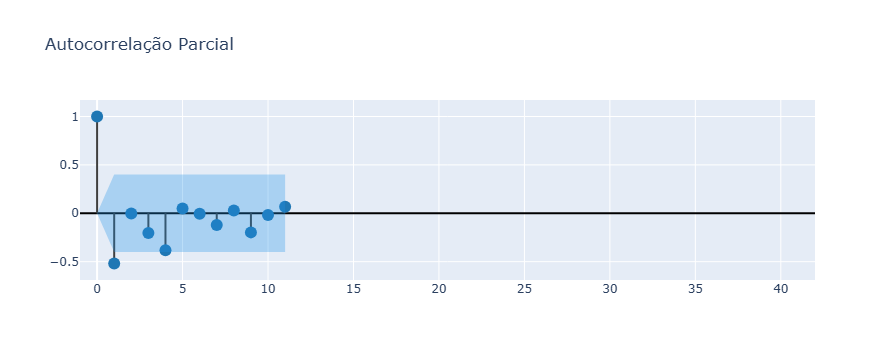

In [559]:
partial_autocorr_plot(df["Nota_Comp1"].diff().dropna())

In [560]:
auto = auto_sarima(df["Nota_Comp1"], min_diff=1, max_diff=2)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[281.181, 1, 1, 0]


C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [561]:
ARIMA(df["Nota_Comp1"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Nota_Comp1   No. Observations:                   25
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -138.590
Date:                Fri, 06 Jun 2025   AIC                            281.181
Time:                        09:19:51   BIC                            283.537
Sample:                             0   HQIC                           281.806
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4812      0.147     -3.276      0.001      -0.769      -0.193
sigma2      5998.7667   1703.906      3.521      0.000    2659.173    9338.361
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.95   Prob(JB):                         0.84
Heteroskedasticity (H):               1.24   Skew:                             0.30
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

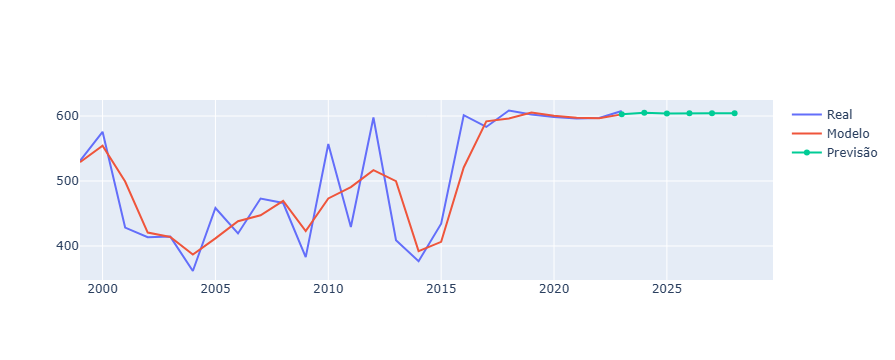

In [562]:
plot_prediction(ARIMA(df["Nota_Comp1"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_Comp1")

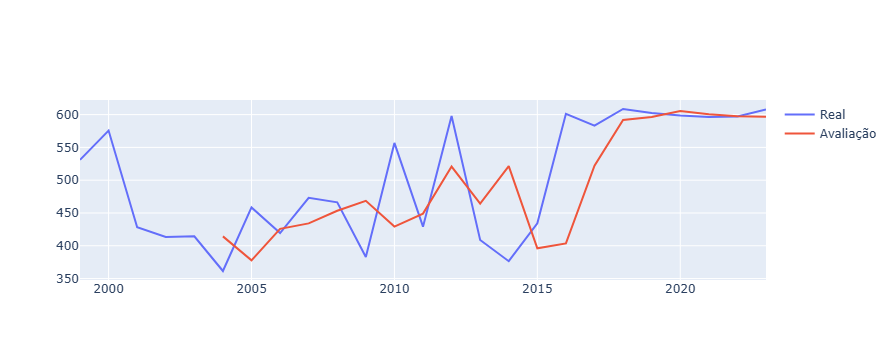

In [563]:
plot_avaliacao(auto, df, "Nota_Comp1", "Ano")

## Competência 2

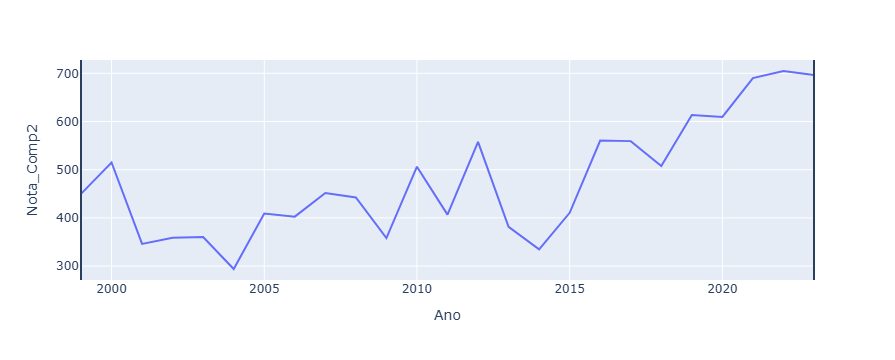

In [565]:
df = reducao_serie(pd.read_excel("MÉDIA_ENEM_COMP_SF.xlsx"), "Ano", "Nota_Comp2")

In [566]:
stationarity_test(df["Nota_Comp2"])

Série estacionária com 1 grau de diferenciação
Série estacionária com 2 graus de diferenciação


In [567]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_Comp2"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


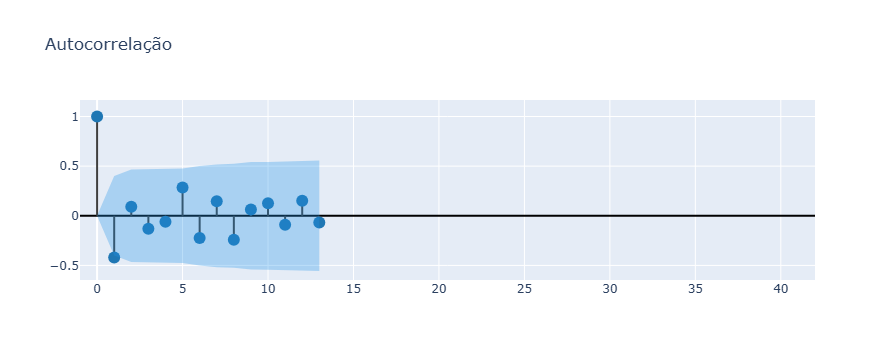

In [568]:
autocorr_plot(df["Nota_Comp2"].diff().dropna())

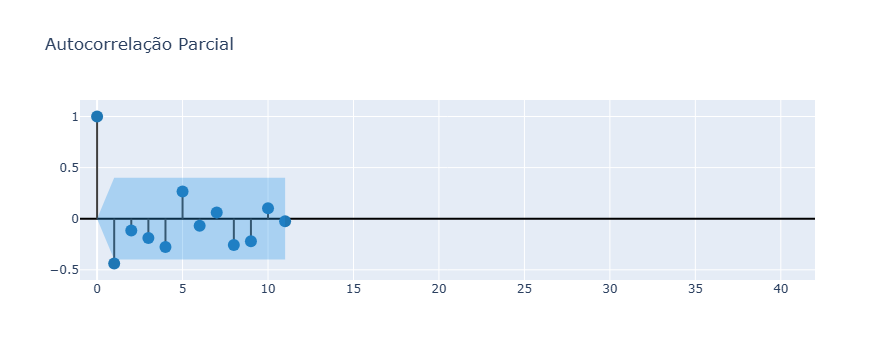

In [569]:
partial_autocorr_plot(df["Nota_Comp2"].diff().dropna())

In [570]:
auto = auto_sarima(df["Nota_Comp2"], min_diff=1, max_diff=1)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[284.241, 1, 1, 0]


C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [571]:
ARIMA(df["Nota_Comp2"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Nota_Comp2   No. Observations:                   25
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -140.121
Date:                Fri, 06 Jun 2025   AIC                            284.241
Time:                        09:19:55   BIC                            286.597
Sample:                             0   HQIC                           284.866
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3955      0.175     -2.262      0.024      -0.738      -0.053
sigma2      6842.0926   2551.415      2.682      0.007    1841.412    1.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.76   Prob(JB):                         0.71
Heteroskedasticity (H):               1.29   Skew:                            -0.22
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

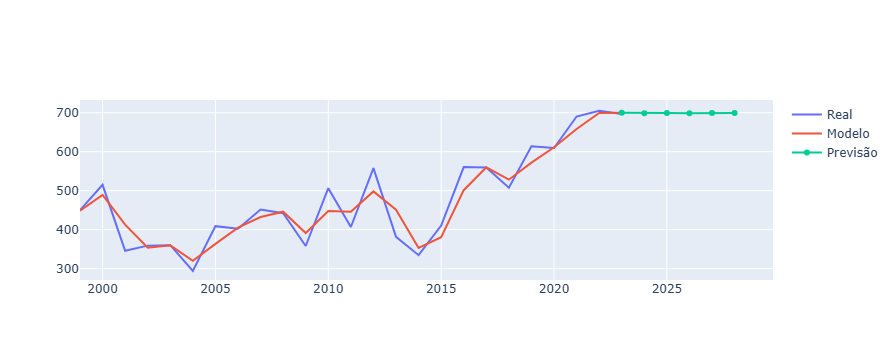

In [572]:
plot_prediction(ARIMA(df["Nota_Comp2"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_Comp2")

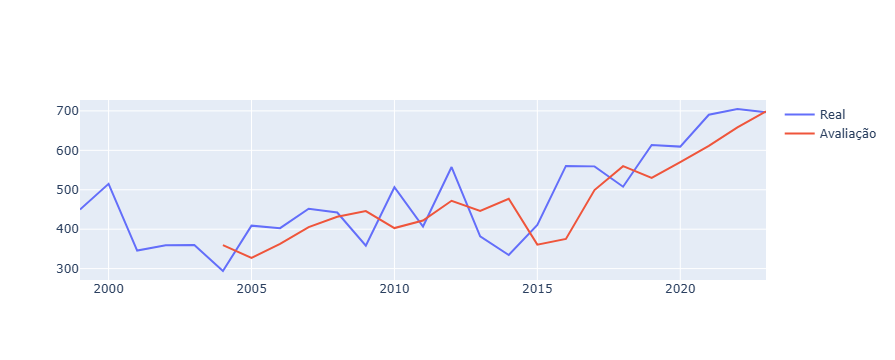

In [573]:
plot_avaliacao(auto, df, "Nota_Comp2", "Ano")

## Competência 3

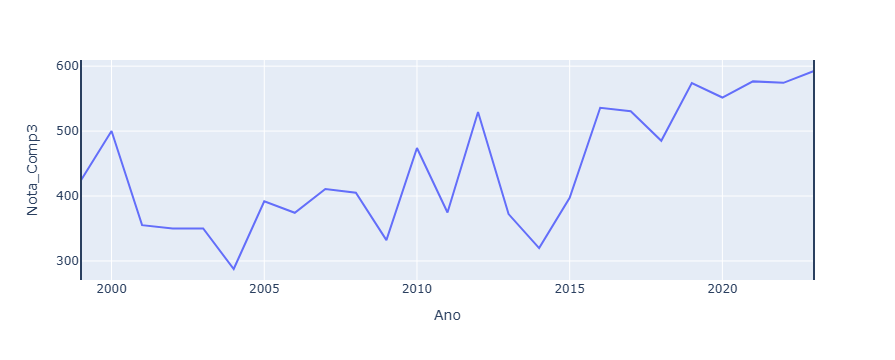

In [575]:
df = reducao_serie(pd.read_excel("MÉDIA_ENEM_COMP_SF.xlsx"), "Ano", "Nota_Comp3")

In [576]:
stationarity_test(df["Nota_Comp3"])

Série estacionária com 1 grau de diferenciação
Série estacionária com 2 graus de diferenciação


In [577]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_Comp3"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


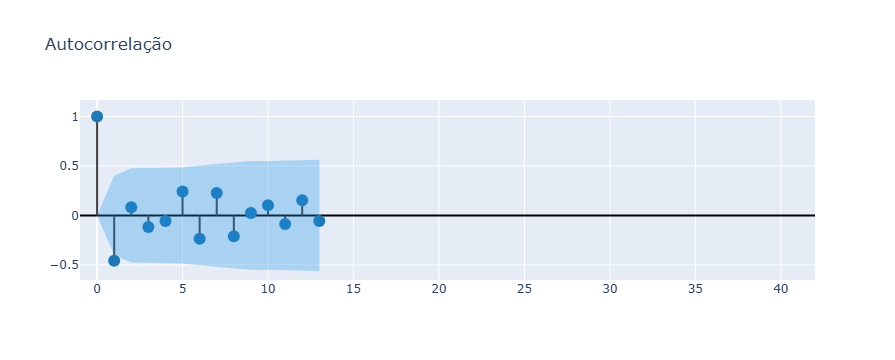

In [578]:
autocorr_plot(df["Nota_Comp3"].diff().dropna())

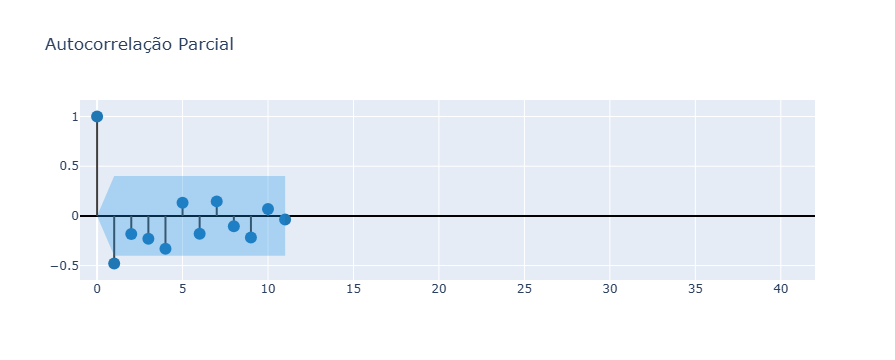

In [579]:
partial_autocorr_plot(df["Nota_Comp3"].diff().dropna())

In [580]:
auto = auto_sarima(df["Nota_Comp3"], min_diff=1, max_diff=1)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[278.084, 0, 1, 1]


C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [581]:
ARIMA(df["Nota_Comp3"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Nota_Comp3   No. Observations:                   25
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -137.042
Date:                Fri, 06 Jun 2025   AIC                            278.084
Time:                        09:19:58   BIC                            280.440
Sample:                             0   HQIC                           278.709
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5300      0.237     -2.238      0.025      -0.994      -0.066
sigma2      5264.2498   1998.915      2.634      0.008    1346.449    9182.051
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.77   Prob(JB):                         0.71
Heteroskedasticity (H):               1.16   Skew:                             0.01
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

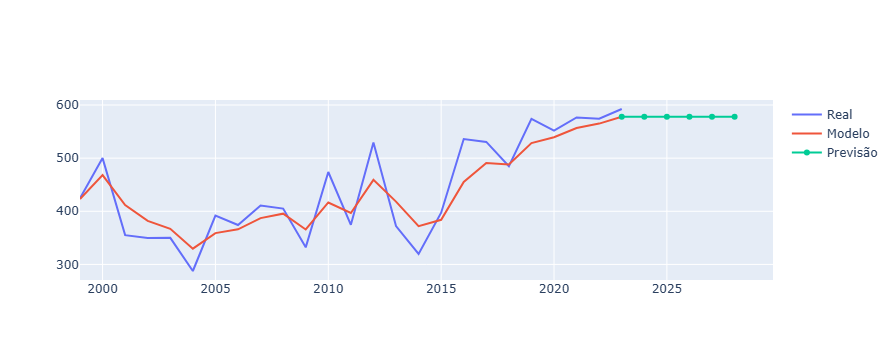

In [582]:
plot_prediction(ARIMA(df["Nota_Comp3"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_Comp3")

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



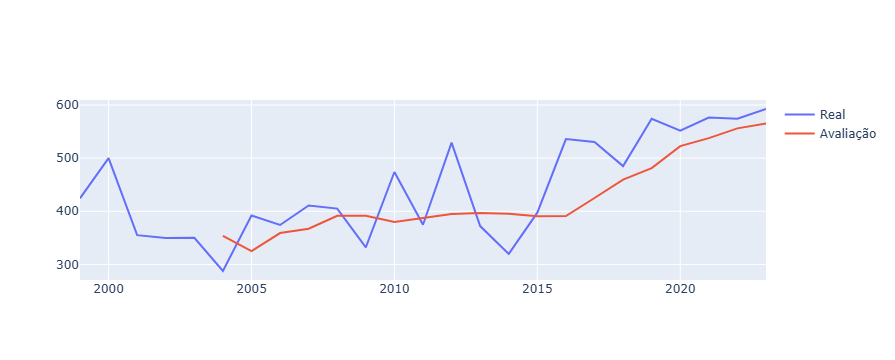

In [583]:
plot_avaliacao(auto, df, "Nota_Comp3", "Ano")

## Competência 4

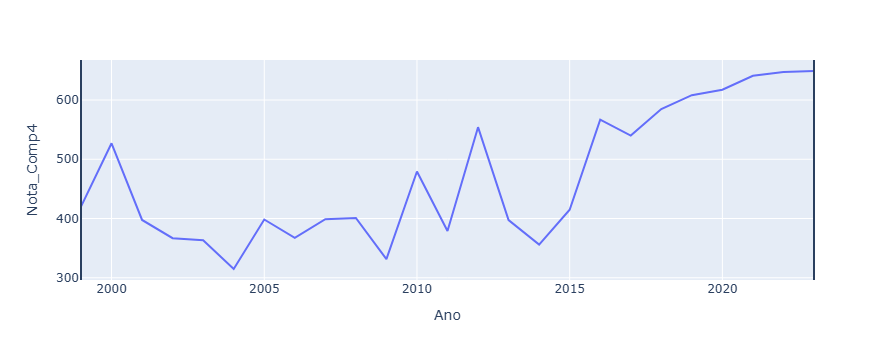

In [585]:
df = reducao_serie(pd.read_excel("MÉDIA_ENEM_COMP_SF.xlsx"), "Ano", "Nota_Comp4")

In [586]:
stationarity_test(df["Nota_Comp4"])

Série estacionária com 1 grau de diferenciação
Série estacionária com 2 graus de diferenciação


In [587]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_Comp4"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


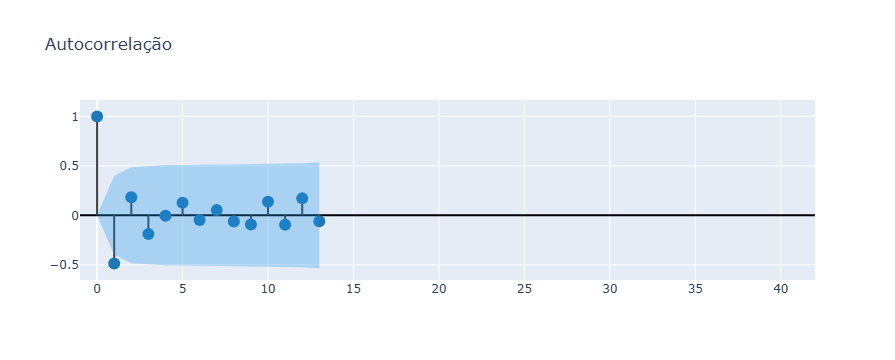

In [588]:
autocorr_plot(df["Nota_Comp4"].diff().dropna())

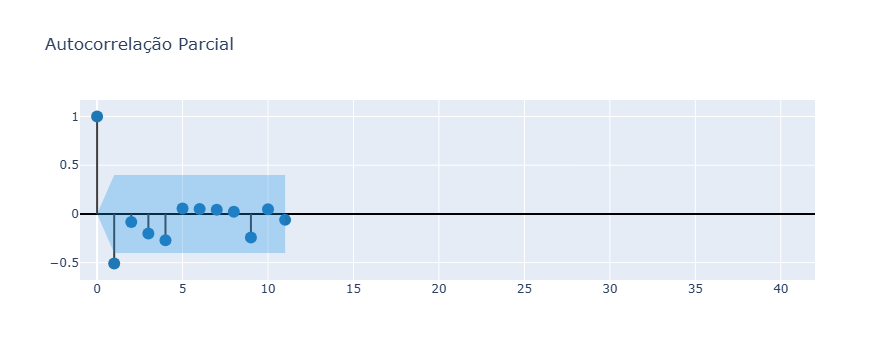

In [589]:
partial_autocorr_plot(df["Nota_Comp4"].diff().dropna())

In [590]:
auto = auto_sarima(df["Nota_Comp4"], min_diff=1, max_diff=1)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[277.829, 1, 1, 0]


C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [591]:
ARIMA(df["Nota_Comp4"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Nota_Comp4   No. Observations:                   25
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -136.914
Date:                Fri, 06 Jun 2025   AIC                            277.829
Time:                        09:20:02   BIC                            280.185
Sample:                             0   HQIC                           278.454
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4859      0.158     -3.069      0.002      -0.796      -0.176
sigma2      5211.5881   1544.353      3.375      0.001    2184.712    8238.465
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.89   Prob(JB):                         0.88
Heteroskedasticity (H):               1.29   Skew:                             0.24
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

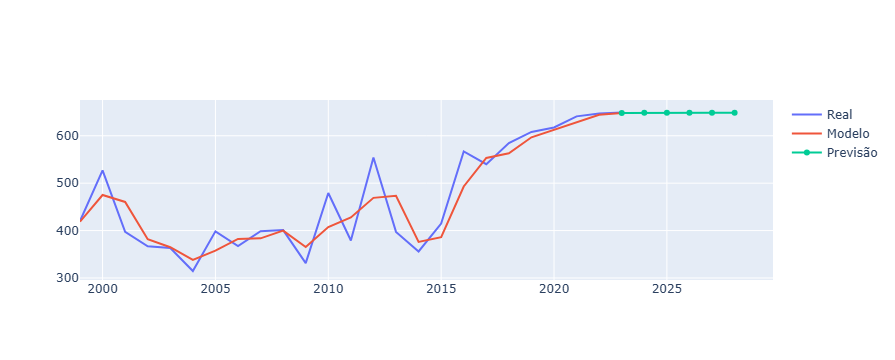

In [592]:
plot_prediction(ARIMA(df["Nota_Comp4"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_Comp4")

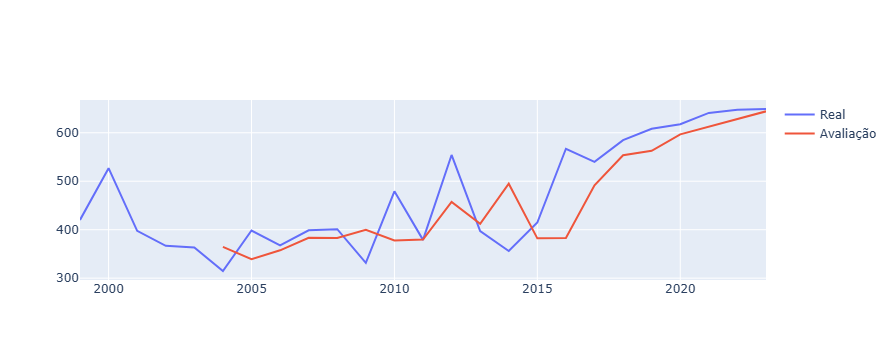

In [593]:
plot_avaliacao(auto, df, "Nota_Comp4", "Ano")

## Competência 5

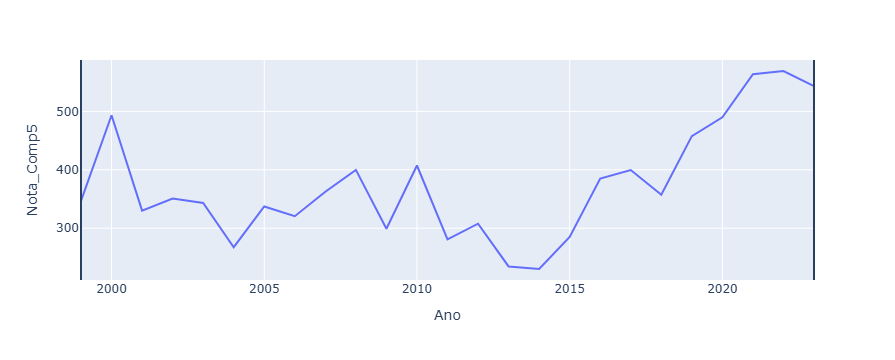

In [595]:
df = reducao_serie(pd.read_excel("MÉDIA_ENEM_COMP_SF.xlsx"), "Ano", "Nota_Comp5")

In [596]:
stationarity_test(df["Nota_Comp5"])

Série estacionária com 1 grau de diferenciação
Série estacionária com 2 graus de diferenciação
Série estacionária com 3 graus de diferenciação


In [597]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_Comp5"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


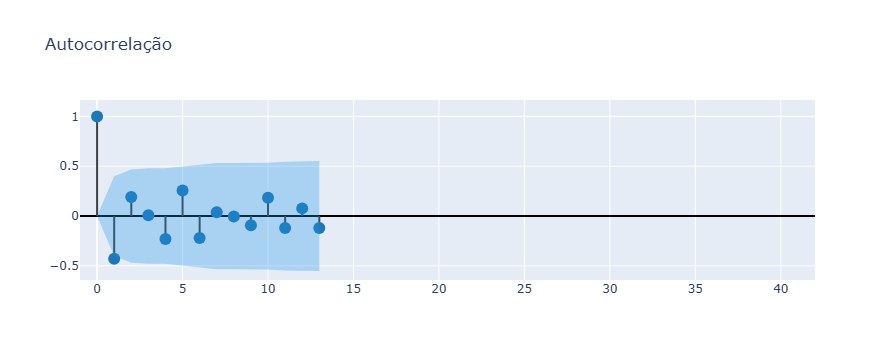

In [598]:
autocorr_plot(df["Nota_Comp5"].diff().dropna())

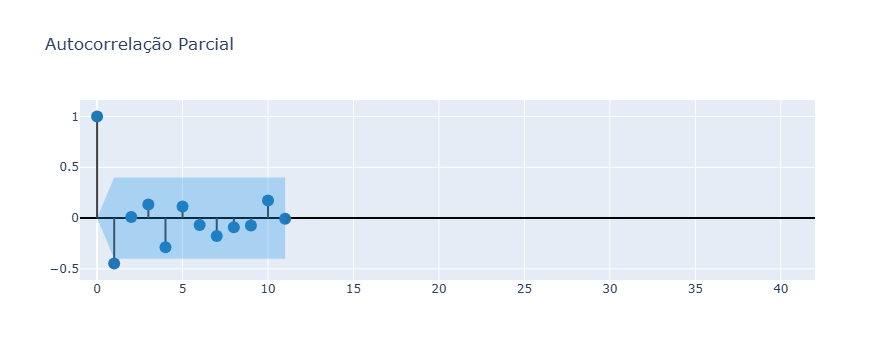

In [599]:
partial_autocorr_plot(df["Nota_Comp5"].diff().dropna())

In [600]:
auto = auto_sarima(df["Nota_Comp5"], min_diff=1, max_diff=1)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[274.71, 1, 1, 0]


C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [601]:
ARIMA(df["Nota_Comp5"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Nota_Comp5   No. Observations:                   25
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -135.355
Date:                Fri, 06 Jun 2025   AIC                            274.710
Time:                        09:20:05   BIC                            277.066
Sample:                             0   HQIC                           275.335
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4719      0.182     -2.598      0.009      -0.828      -0.116
sigma2      4578.9252   2016.079      2.271      0.023     627.483    8530.367
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.74   Prob(JB):                         0.50
Heteroskedasticity (H):               1.16   Skew:                             0.02
Prob(H) (two-sided):                  0.84   Kurtosis:                         1.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

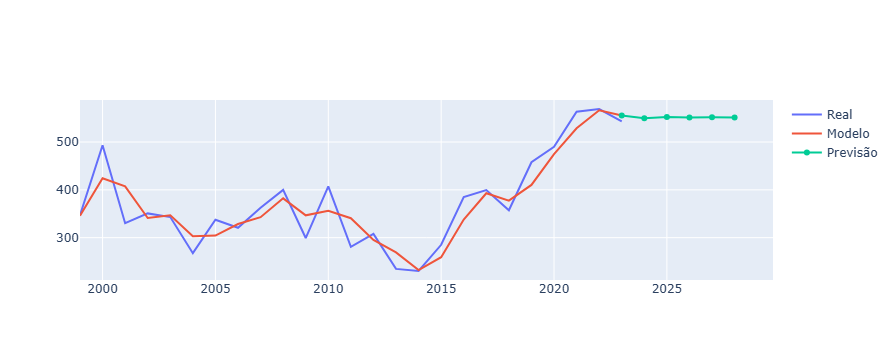

In [602]:
plot_prediction(ARIMA(df["Nota_Comp5"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_Comp5")

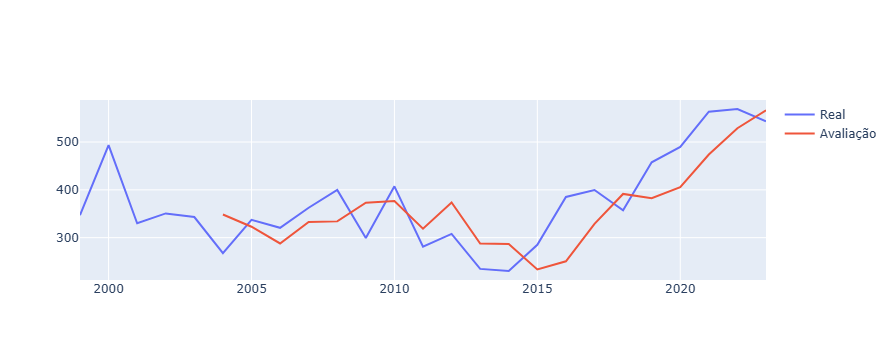

In [603]:
plot_avaliacao(auto, df, "Nota_Comp5", "Ano")

## Inscrições

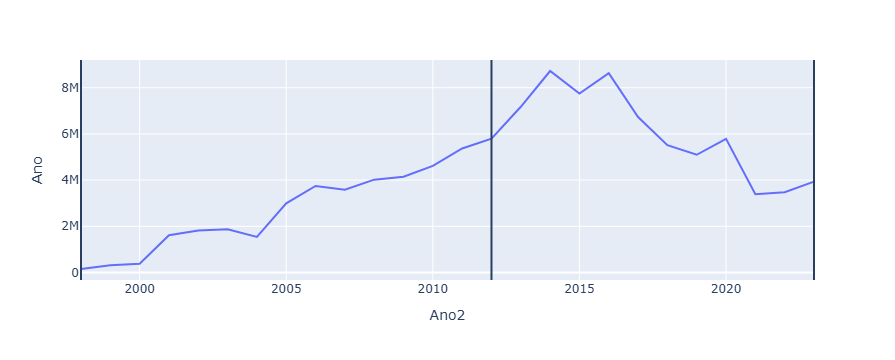

In [605]:
df = reducao_serie(pd.read_excel("INSCRITO_ENEM_SF.xlsx"), "Ano2", "Ano")

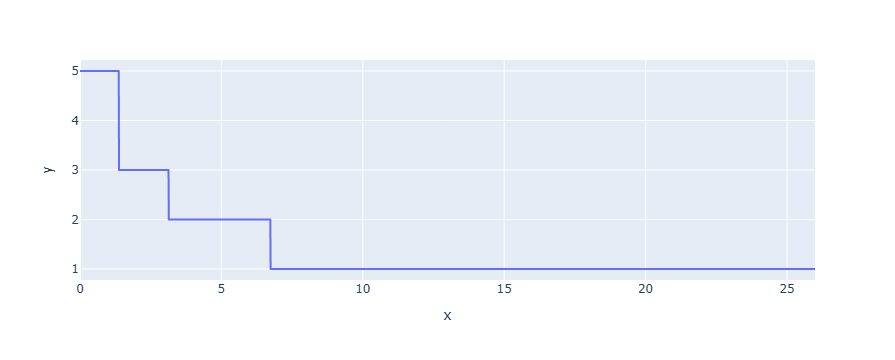

In [606]:
cotovelo(pd.read_excel("INSCRITO_ENEM_SF.xlsx"), "Ano2", "Ano")

In [607]:
stationarity_test(df["Ano"])

Série estacionária com 3 graus de diferenciação


In [608]:
for i in range(2, len(df)):
    seasonality_test(df["Ano"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 3
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 4
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 6


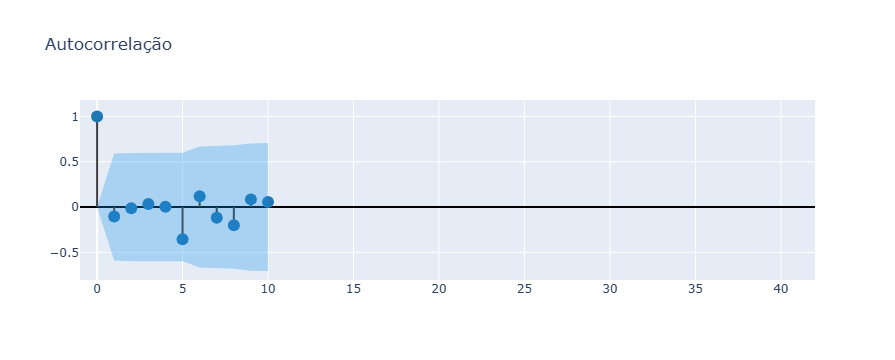

In [609]:
autocorr_plot(df["Ano"].diff().dropna())

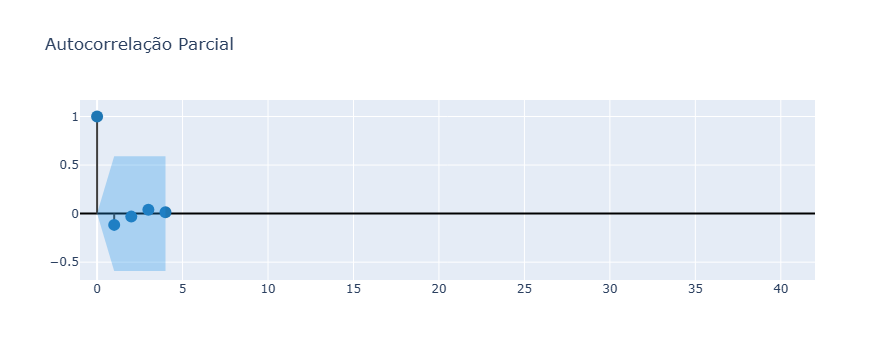

In [610]:
partial_autocorr_plot(df["Ano"].diff().dropna())

In [611]:
auto = auto_sarima(df["Ano"], min_diff=1, max_diff=1)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[342.438, 0, 1, 0]


C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is depreca

In [612]:
ARIMA(df["Ano"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Ano   No. Observations:                   12
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -170.219
Date:                Fri, 06 Jun 2025   AIC                            342.438
Time:                        09:20:09   BIC                            342.836
Sample:                             0   HQIC                           342.187
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.476e+12   7.84e+11      1.881      0.060   -6.17e+10    3.01e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.69   Prob(JB):                         0.68
Heteroskedasticity (H):               1.06   Skew:                            -0.32
Prob(H) (two-sided):                  0.95   Kurtosis:                         1.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

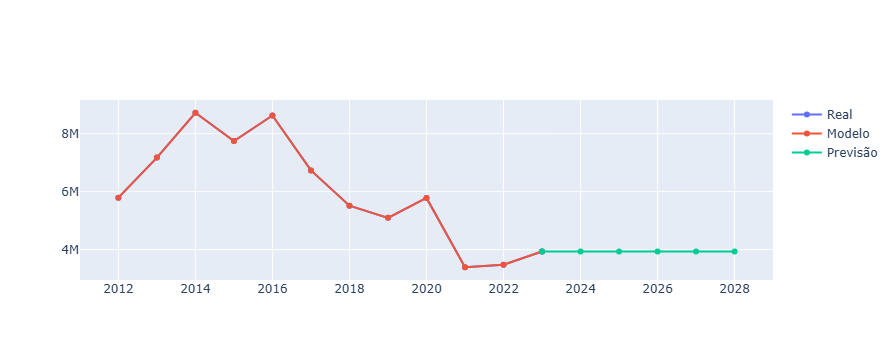

In [613]:
plot_prediction(ARIMA(df["Ano"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano2", "Ano")

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was pro

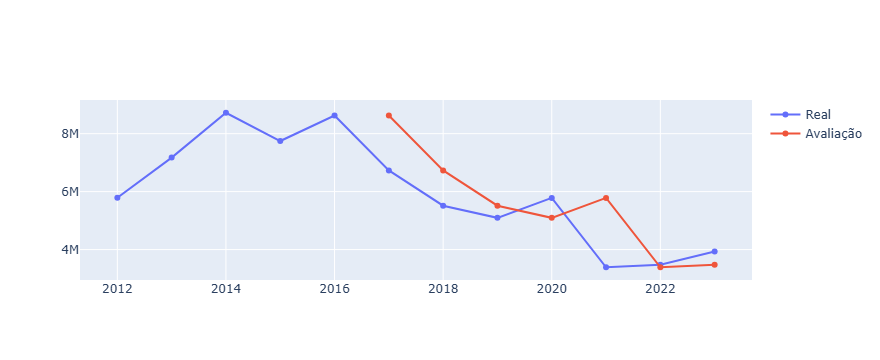

In [614]:
plot_avaliacao(auto, df, "Ano", "Ano2")

## Presença

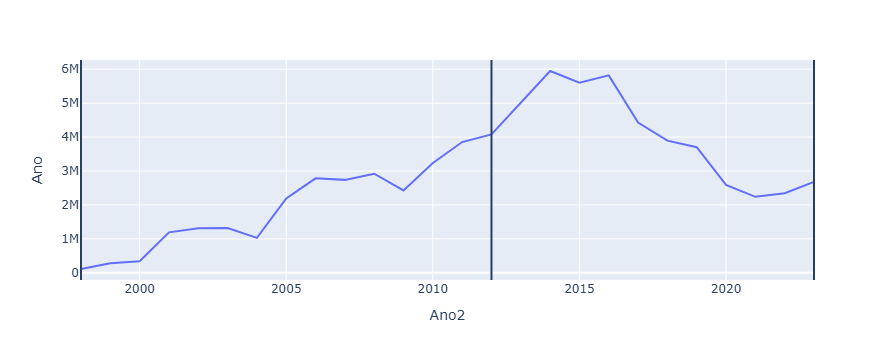

In [616]:
df = pd.read_excel("PRESENÇA_ENEM_SF.xlsx")
df = df[df["Presenca"] == 1]
df = reducao_serie(df, "Ano2", "Ano")

In [617]:
stationarity_test(df["Ano"])

Série estacionária com 3 graus de diferenciação


In [618]:
for i in range(2, len(df)):
    seasonality_test(df["Ano"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 3
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 4
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 6


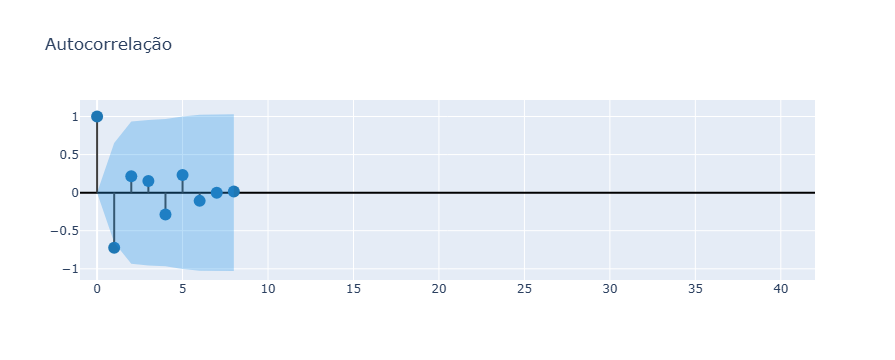

In [619]:
autocorr_plot(df["Ano"].diff().diff().diff().dropna())

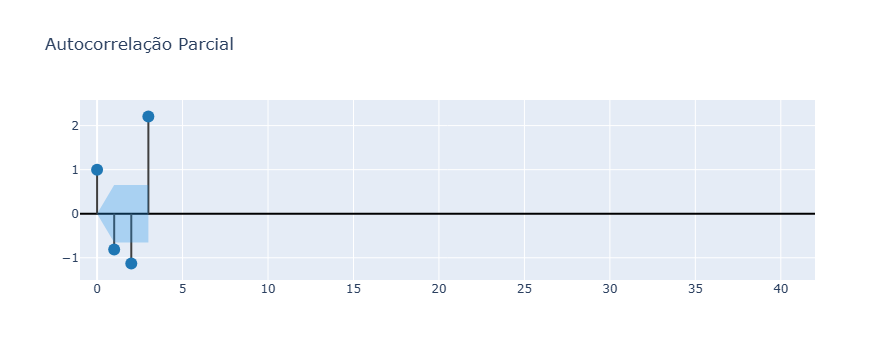

In [620]:
partial_autocorr_plot(df["Ano"].diff().diff().diff().dropna())

In [621]:
auto = auto_sarima(df["Ano"], min_diff=3, max_diff=3)
print(auto)

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\yan_k\anaconda3\Lib\s

[276.605, 1, 3, 1]


C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Use

In [622]:
ARIMA(df["Ano"], order=(auto[1], auto[2], auto[3])).fit().summary()

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Ano   No. Observations:                   12
Model:                 ARIMA(1, 3, 1)   Log Likelihood                -135.303
Date:                Fri, 06 Jun 2025   AIC                            276.605
Time:                        09:20:11   BIC                            277.197
Sample:                             0   HQIC                           275.328
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6639      0.194     -3.424      0.001      -1.044      -0.284
ma.L1         -0.4728      0.181     -2.609      0.009      -0.828      -0.118
sigma2      6.147e+11   7.96e-14   7.73e+24      0.000    6.15e+11    6.15e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.96   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.16   Prob(JB):                         0.72
Heteroskedasticity (H):               0.92   Skew:                            -0.09
Prob(H) (two-sided):                  0.95   Kurtosis:                         1.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.28e+41. Standard errors may be unstable.
"""

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\yan_k\anaconda3\Lib

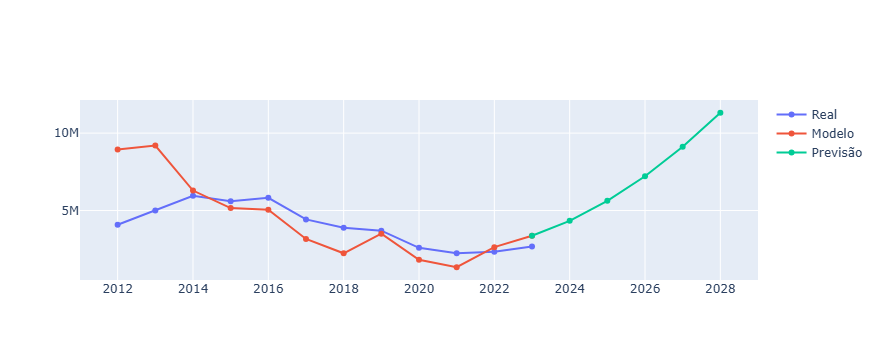

In [623]:
plot_prediction(ARIMA(df["Ano"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano2", "Ano")

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

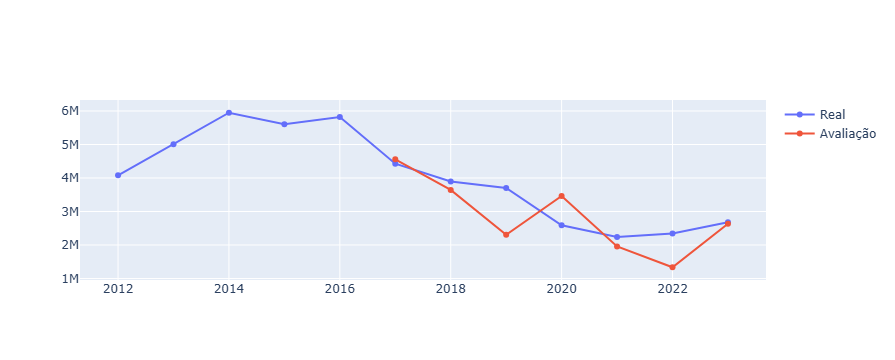

In [624]:
plot_avaliacao(auto, df, "Ano", "Ano2")

## Ciências Naturais

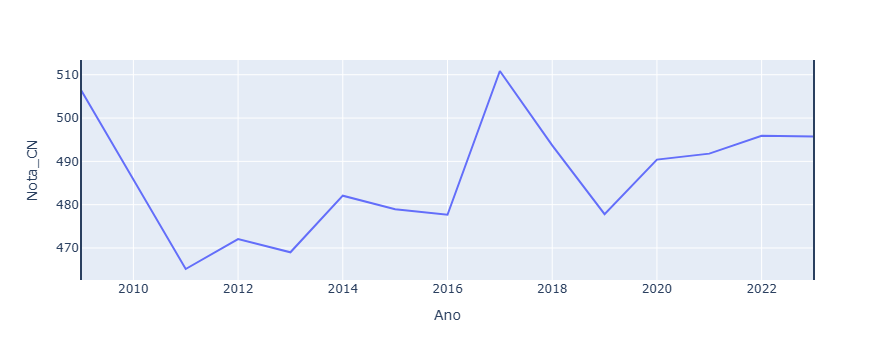

In [626]:
df = reducao_serie(pd.read_excel("MÉDIA_PROVAS_ENEM_SF.xlsx"), "Ano", "Nota_CN")

In [627]:
stationarity_test(df["Nota_CN"])

Série estacionária com 2 graus de diferenciação


In [628]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_CN"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 3
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


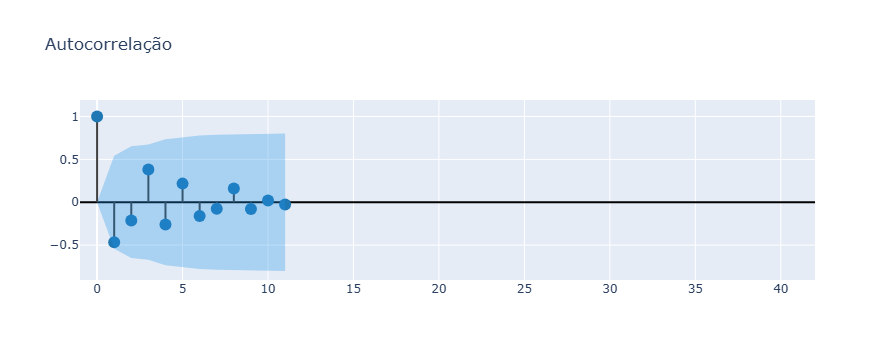

In [629]:
autocorr_plot(df["Nota_CN"].diff().diff().dropna())

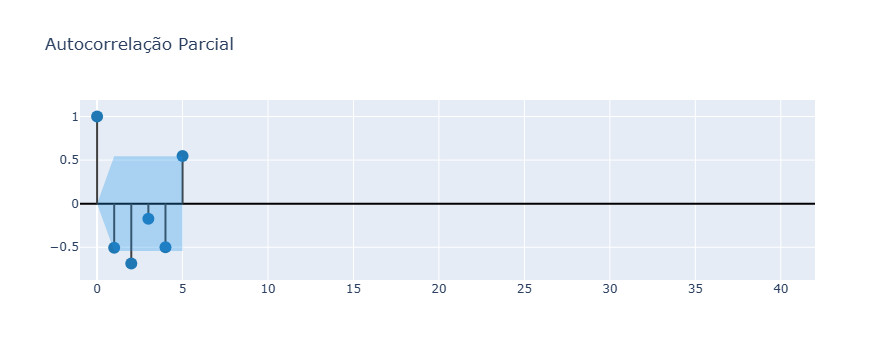

In [630]:
partial_autocorr_plot(df["Nota_CN"].diff().diff().dropna())

In [631]:
auto = auto_sarima(df["Nota_CN"], min_diff=2, max_diff=2)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmode

Não foi possível encontrar uma série com com covaráveis significativas a 5% de significância, tentando novamente com 40%


C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:93: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:77: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:93: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To re

[[118.786, 0, 2, 0], [117.925, 1, 2, 0], [115.29, 2, 2, 0]]
[115.29, 2, 2, 0]


C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:77: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:93: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [632]:
ARIMA(df["Nota_CN"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Nota_CN   No. Observations:                   15
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 -54.645
Date:                Fri, 06 Jun 2025   AIC                            115.290
Time:                        09:20:17   BIC                            116.985
Sample:                             0   HQIC                           114.941
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6961      0.255     -2.732      0.006      -1.196      -0.197
ar.L2         -0.5468      0.281     -1.943      0.052      -1.098       0.005
sigma2       244.2680    151.635      1.611      0.107     -52.930     541.466
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.66   Prob(JB):                         0.81
Heteroskedasticity (H):               0.23   Skew:                            -0.11
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

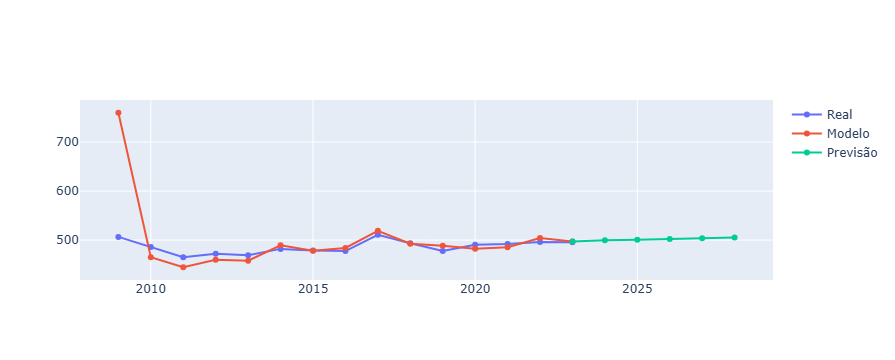

In [633]:
plot_prediction(ARIMA(df["Nota_CN"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_CN")

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



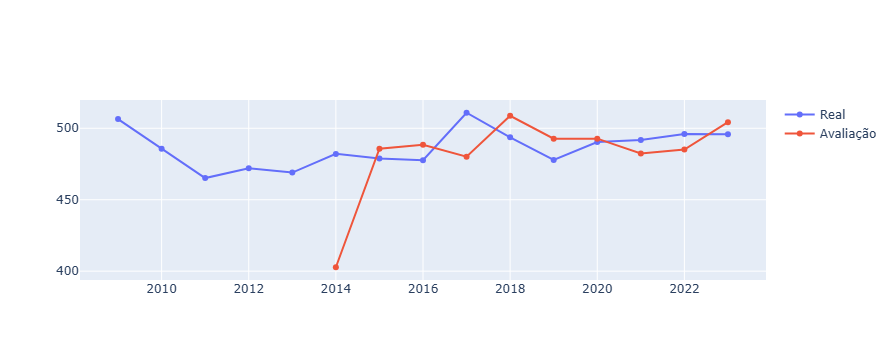

In [634]:
plot_avaliacao(auto, df, "Nota_CN", "Ano")

## Ciências Humanas

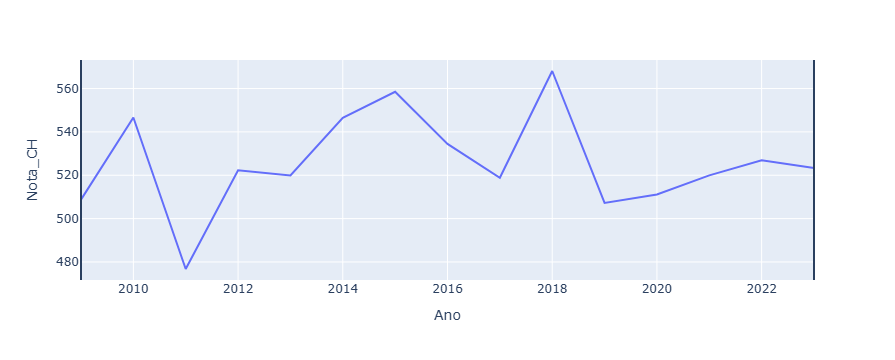

In [636]:
df = reducao_serie(pd.read_excel("MÉDIA_PROVAS_ENEM_SF.xlsx"), "Ano", "Nota_CH")

In [637]:
stationarity_test(df["Nota_CH"])

Série estacionária com 0 graus de diferenciação
Série estacionária com 1 grau de diferenciação
Série estacionária com 3 graus de diferenciação


In [638]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_CH"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 3
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


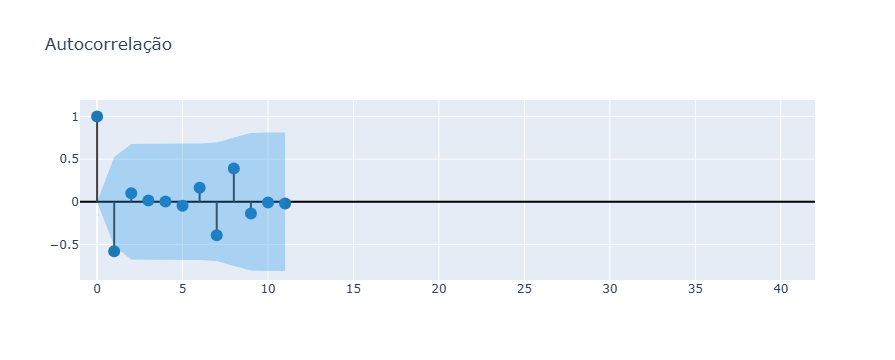

In [639]:
autocorr_plot(df["Nota_CH"].diff().dropna())

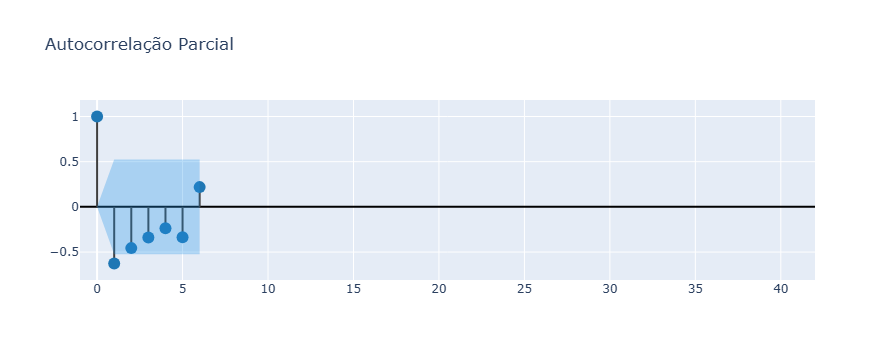

In [640]:
partial_autocorr_plot(df["Nota_CH"].diff().dropna())

In [641]:
auto = auto_sarima(df["Nota_CH"], min_diff=0, max_diff=1)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[136.594, 1, 1, 0]


C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [642]:
ARIMA(df["Nota_CH"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Nota_CH   No. Observations:                   15
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -66.297
Date:                Fri, 06 Jun 2025   AIC                            136.594
Time:                        09:20:23   BIC                            137.872
Sample:                             0   HQIC                           136.476
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5931      0.224     -2.646      0.008      -1.033      -0.154
sigma2       735.5219    505.654      1.455      0.146    -255.541    1726.585
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.46   Prob(JB):                         0.56
Heteroskedasticity (H):               0.52   Skew:                            -0.34
Prob(H) (two-sided):                  0.49   Kurtosis:                         1.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

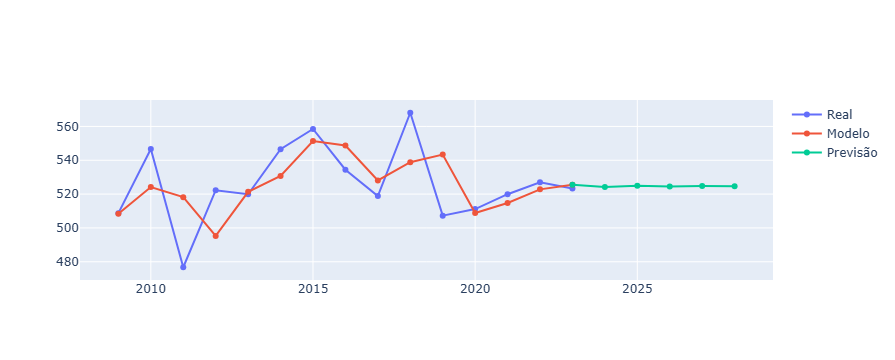

In [643]:
plot_prediction(ARIMA(df["Nota_CH"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_CH")

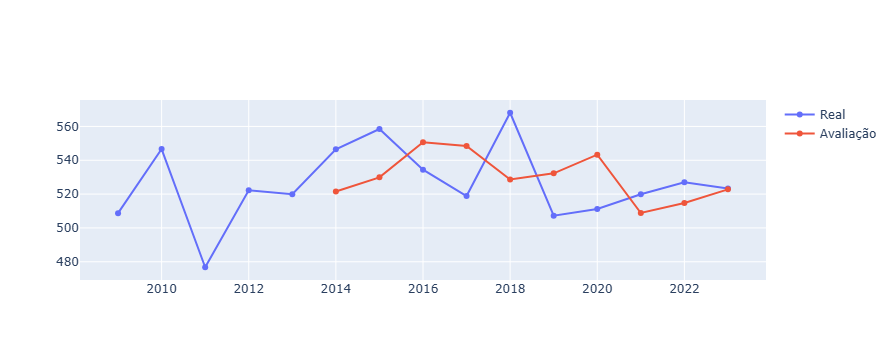

In [644]:
plot_avaliacao(auto, df, "Nota_CH", "Ano")

## Linguagens e Códigos

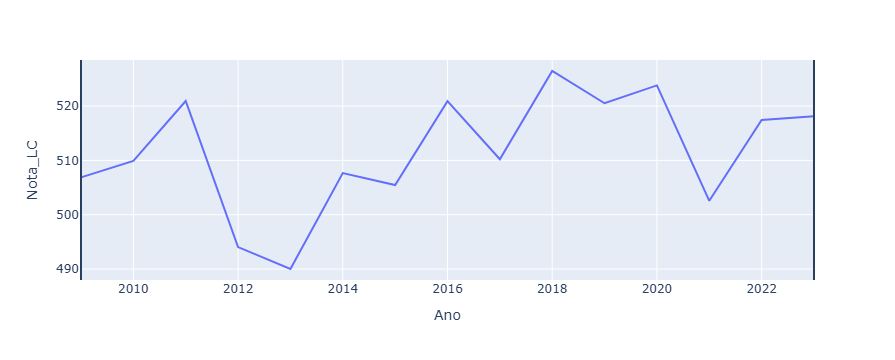

In [646]:
df = reducao_serie(pd.read_excel("MÉDIA_PROVAS_ENEM_SF.xlsx"), "Ano", "Nota_LC")

In [647]:
stationarity_test(df["Nota_LC"])

Série estacionária com 1 grau de diferenciação
Série estacionária com 2 graus de diferenciação
Série estacionária com 3 graus de diferenciação


In [648]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_LC"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 3
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


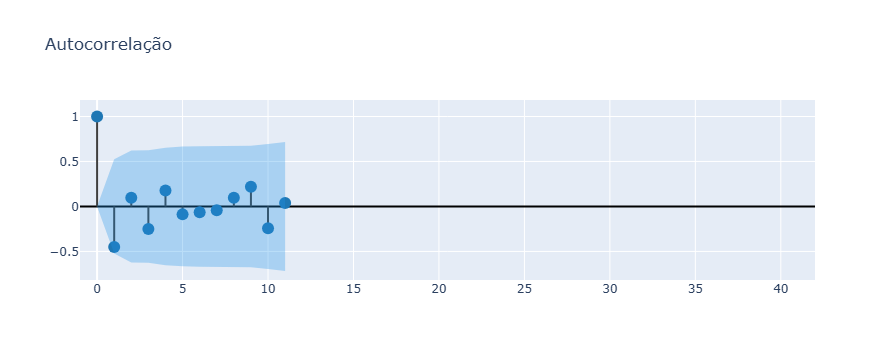

In [649]:
autocorr_plot(df["Nota_LC"].diff().dropna())

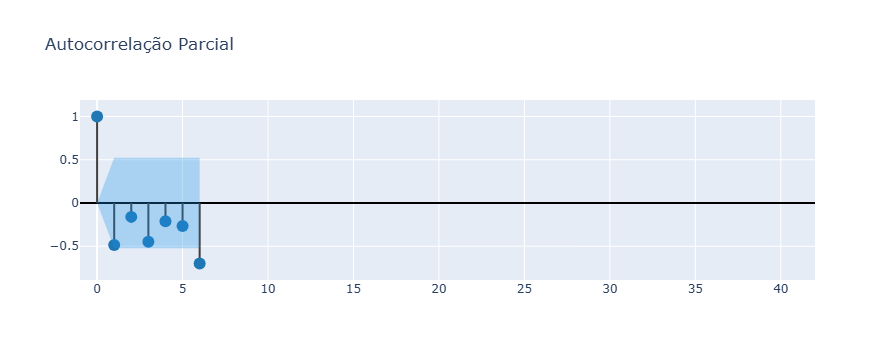

In [650]:
partial_autocorr_plot(df["Nota_LC"].diff().dropna())

In [651]:
auto = auto_sarima(df["Nota_LC"], min_diff=1, max_diff=2)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522

[112.046, 0, 1, 1]


C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [652]:
ARIMA(df["Nota_LC"], order=(auto[1], auto[2], auto[3])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Nota_LC   No. Observations:                   15
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -54.023
Date:                Fri, 06 Jun 2025   AIC                            112.046
Time:                        09:20:28   BIC                            113.324
Sample:                             0   HQIC                           111.927
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7043      0.243     -2.894      0.004      -1.181      -0.227
sigma2       125.2923     68.027      1.842      0.066      -8.038     258.623
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.91   Prob(JB):                         0.54
Heteroskedasticity (H):               0.46   Skew:                            -0.67
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

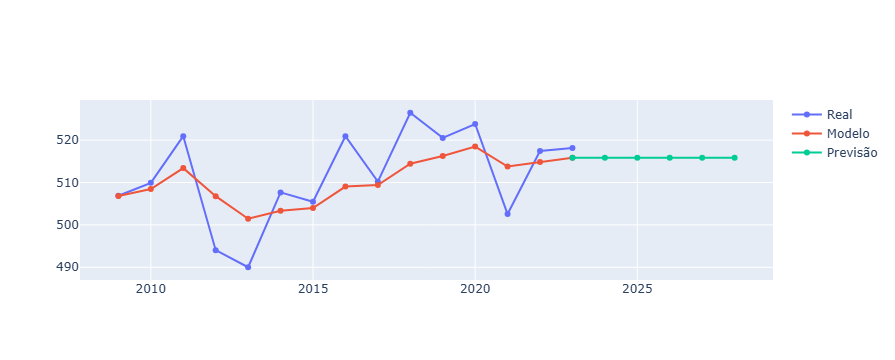

In [653]:
plot_prediction(ARIMA(df["Nota_LC"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_LC")

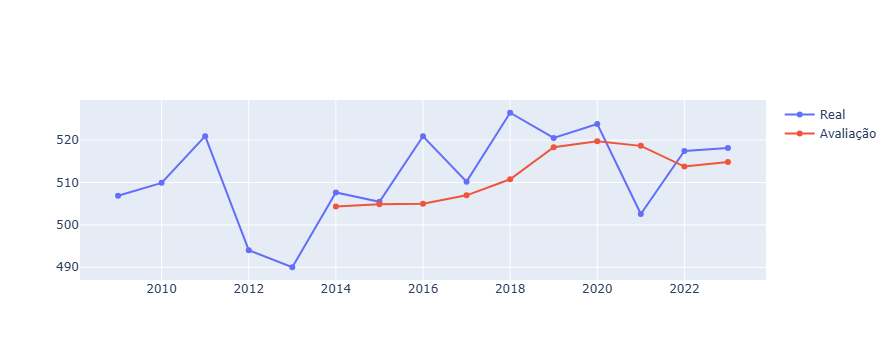

In [654]:
plot_avaliacao(auto, df, "Nota_LC", "Ano")

## Matemática

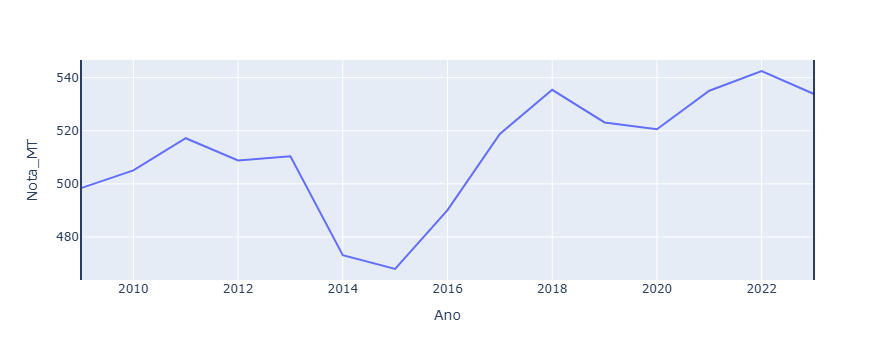

In [656]:
df = reducao_serie(pd.read_excel("MÉDIA_PROVAS_ENEM_SF.xlsx"), "Ano", "Nota_MT")

In [657]:
stationarity_test(df["Nota_MT"])

Série estacionária com 0 graus de diferenciação
Série estacionária com 1 grau de diferenciação
Série estacionária com 3 graus de diferenciação


In [658]:
for i in range(2, len(df)):
    seasonality_test(df["Nota_MT"], i)

Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 3
Friedman Chi-Square: Não-sazonal a 5% de significância com temporada 5


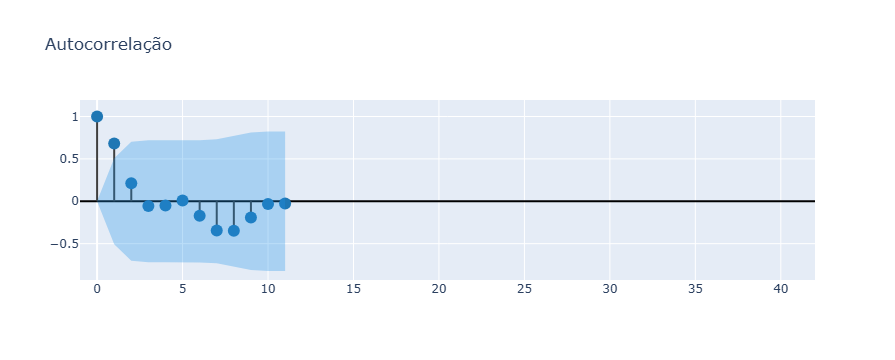

In [659]:
autocorr_plot(df["Nota_MT"].dropna())

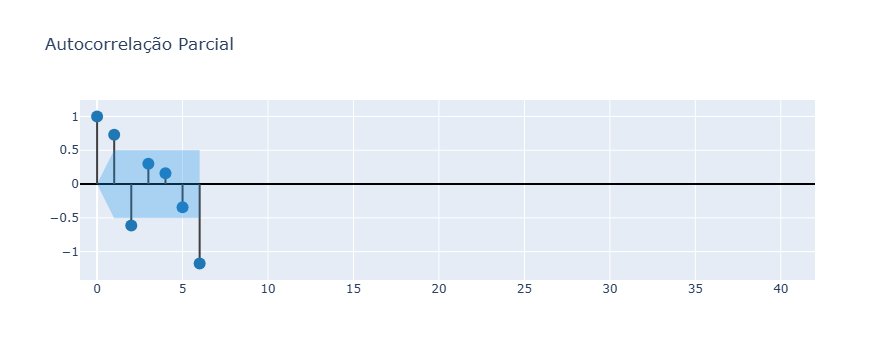

In [660]:
partial_autocorr_plot(df["Nota_MT"].dropna())

In [661]:
auto = auto_sarima(df["Nota_MT"], min_diff=0, max_diff=0)
print(auto)

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:20: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to '

[130.379, 0, 0, 1]


C:\Users\yan_k\AppData\Local\Temp\ipykernel_8356\522848796.py:36: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [662]:
ARIMA(df["Nota_MT"], order=(auto[1], auto[2], auto[3])).fit().summary()

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Nota_MT   No. Observations:                   15
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -62.190
Date:                Fri, 06 Jun 2025   AIC                            130.379
Time:                        09:20:31   BIC                            132.503
Sample:                             0   HQIC                           130.356
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        512.5237      8.906     57.549      0.000     495.068     529.979
ma.L1          0.7979      0.258      3.098      0.002       0.293       1.303
sigma2       218.4630     77.417      2.822      0.005      66.729     370.197
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):                 5.40
Prob(Q):                              0.20   Prob(JB):                         0.07
Heteroskedasticity (H):               3.37   Skew:                            -1.25
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



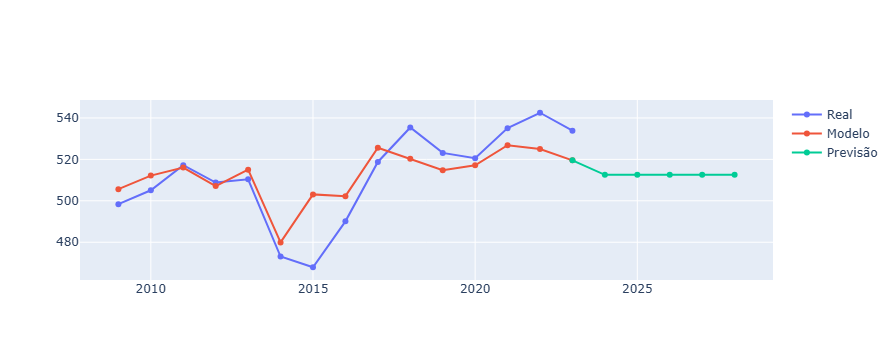

In [663]:
plot_prediction(ARIMA(df["Nota_MT"], order=(auto[1], auto[2], auto[3])).fit(), df, "Ano", "Nota_MT")

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\yan_k\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



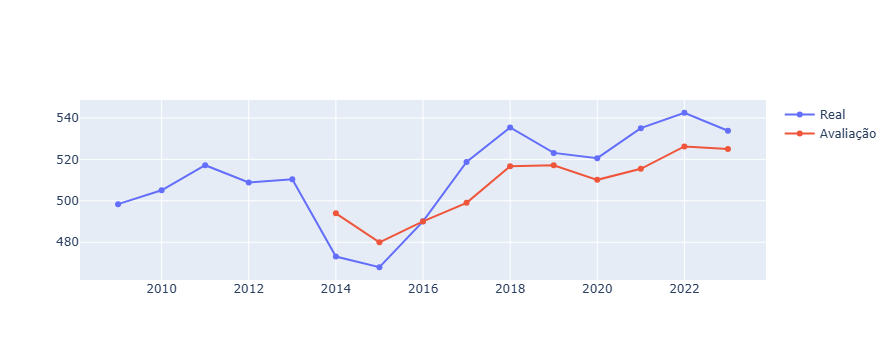

In [664]:
plot_avaliacao(auto, df, "Nota_MT", "Ano")

# Análise Exploratória

## Competências

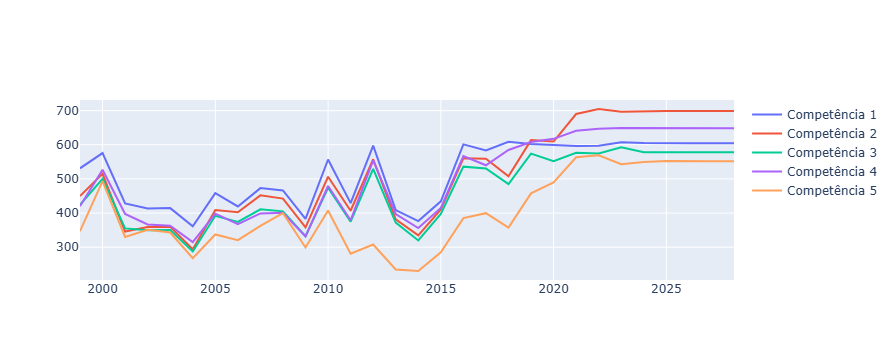

In [667]:
df = pd.read_excel("MÉDIA_ENEM_COMP_SF_PREVISAO.xlsx")

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_Comp1'], mode='lines', name='Competência 1'))
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_Comp2'], mode='lines', name='Competência 2'))
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_Comp3'], mode='lines', name='Competência 3'))
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_Comp4'], mode='lines', name='Competência 4'))
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_Comp5'], mode='lines', name='Competência 5'))

fig.show()

## Provas

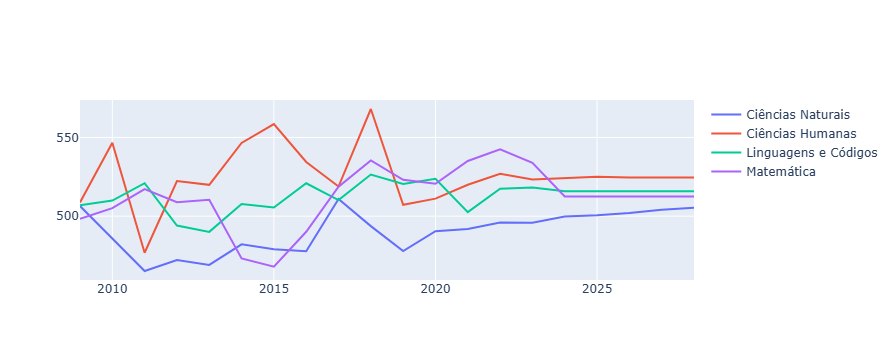

In [669]:
df = pd.read_excel("MÉDIA_PROVAS_ENEM_SF_PREVISAO.xlsx")

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_CN'], mode='lines', name='Ciências Naturais'))
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_CH'], mode='lines', name='Ciências Humanas'))
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_LC'], mode='lines', name='Linguagens e Códigos'))
fig.add_trace(go.Scatter(x=df['Ano'], y=df['Nota_MT'], mode='lines', name='Matemática'))

fig.show()